In [51]:
# libraries importation

import pandas as pd
import re
import string
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import *
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.corpus import names
import random

In [7]:
news = pd.read_csv('./data/news_dataset.csv', index_col=0)

In [8]:
news.head()

,author,body,h1,h2,label,url
0,NaN,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",NaN,False,http://elmetropolitanodemadrid.blogspot.com/20...
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,NaN,False,http://murciatransparente.net/partido-popular-...
2,NaN,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,NaN,False,http://www.12minutos.com/5c255a4e64b9a/manuela...
3,NaN,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,NaN,False,http://viraladvertising.over-blog.com/2018/11/...


True     500
False    262
Name: label, dtype: int64

Preparing Text Data For Analysis

functions for cleaning, tokenizing, stemming and lemmatizing data and for deleting stop words

In [11]:
# function for cleaning

def clean_up_text(text):
    """
    The function cleans up numbers, remove punctuation and line break, and special characters from a string 
    and converts it to lowercase.

    Args:
        text: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text) 
    text = re.sub('\w*\d\w*', '', text)    
    text = re.sub('[‘’“”…«»¿?¡!\-_\(\)]', '', text)
    text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
  
    return text



In [12]:
# function for tokenizing

def tokenize_text(text):
        """
        Tokenize a string.

        Args:
            text: String to be tokenized.

        Returns:
            A list of words as the result of tokenization.
        """
        return word_tokenize(text)


In [13]:
# function for stemming, and lemmatizing

def stem_and_lemmatize(list_of_words):
    """
    Perform stemming and lemmatization on a list of words.

    Args:
        list_of_words: A list of strings.

    Returns:
        A list of strings after being stemmed and lemmatized.
    """
    stemmer = nltk.stem.SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    stemmed_lemmantized_list = [stemmer.stem(lemmatizer.lemmatize(word)) for word in list_of_words]
    return stemmed_lemmantized_list

In [14]:
# function for stops words

def remove_stopwords(list_of_words):
    """
    Remove English stopwords from a list of strings.

    Args:
        list_of_words: A list of strings.

    Returns:
        A list of strings after stop words are removed.
    """
    spanish_stop_words = stopwords.words('spanish')
      
    return [w for w in list_of_words if not w in spanish_stop_words]


Executing cleaning, tokenizing, stemming, lemmatizing and deleting stop words functions

In [15]:
news['processed_body'] = news['body'].apply(lambda x: clean_up_text(str(x)))

In [16]:
news['processed_body'] = news['processed_body'].apply(tokenize_text)

In [17]:
news['processed_body'] = news['processed_body'].apply(stem_and_lemmatize)

In [18]:
news['processed_body'] = news['processed_body'].apply(remove_stopwords)

In [19]:
news.head()

,author,body,h1,h2,label,url,processed_body
0,NaN,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",NaN,False,http://elmetropolitanodemadrid.blogspot.com/20...,"[ojal, bomb, ahor, colon, dond, estan, terror,..."
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,NaN,False,http://murciatransparente.net/partido-popular-...,"[comparecent, dign, club, comedi, rafael, hern..."
2,NaN,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,NaN,False,http://www.12minutos.com/5c255a4e64b9a/manuela...,"[segun, inform, digital, cadenaz, alcaldes, ma..."
3,NaN,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...,"[si, nuestr, ultim, notici, anunci, propuest, ..."
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,NaN,False,http://viraladvertising.over-blog.com/2018/11/...,"[lid, pp, dic, har, posibl, par, imped, salari..."


Creating Bag of Words.
 The bag of words contains all the unique words in your whole text body

In [20]:
# Creating a bag of words from the processed data.


bag_of_words = []
for word in news.processed_body:
    bag_of_words += word



Building Features

    Using the top 5,000 words, we create a diccionary to record whether each of those words is    
    contained in each document (new's text). 
    Nest to the dicctionary, we add the label is True o False.
    So, we get a set with a dictionary and the label.

In [171]:
# Selecting the most important words to build the features with NLTK's FreqDist

# Calling Freqdist()

fdist = FreqDist(bag_of_words)


# Selecting the top 5,000 words from the frequency distribution with most_common().

selected = fdist.most_common(10000)

top_words = [x[0] for x in selected]


In [172]:
# Function to generate the features and label tuple.

def find_features(text_of_new, label):
    words = set(text_of_new)
    features = {}
    for w in top_words:
        features[w] = (w in words)
    result = label
    return (features, result)

In [173]:
# find_features() execution on news' text

features = list(news.apply(lambda x: find_features(x['processed_body'], x['label']), axis=1))


In [40]:
features[0][0]

{'par': False,
 'com': False,
 'mas': False,
 'tod': False,
 'per': False,
 'si': False,
 'part': False,
 'hac': False,
 'pas': False,
 'tambien': False,
 'años': False,
 'ser': False,
 'nuev': False,
 'hab': False,
 'sol': False,
 'pued': False,
 'do': False,
 'desd': False,
 'cas': False,
 'sobr': False,
 'tien': False,
 'ten': False,
 'pais': False,
 'cuand': True,
 'much': False,
 'hast': False,
 'public': False,
 'españ': False,
 'segun': False,
 'primer': False,
 'trabaj': False,
 'madr': False,
 'año': False,
 'pod': False,
 'porqu': False,
 'lleg': False,
 'mism': False,
 'mayor': False,
 'español': False,
 'contr': False,
 'gobiern': False,
 'deb': False,
 'ultim': False,
 'dond': True,
 'president': False,
 'person': False,
 'algun': False,
 'inform': False,
 'ahor': True,
 'llev': False,
 'tras': False,
 'millon': False,
 'despues': False,
 'asi': False,
 'durant': False,
 'explic': False,
 'sid': False,
 'cambi': False,
 'polit': False,
 'estan': True,
 'mejor': False,
 've

In [116]:
'''
train_set, test_set = features[:48] + features[60:108], features[48:60] + features[108:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, test_set))*100)
Classifier accuracy percent: 58.333333333333336
'''

Classifier accuracy percent: 58.333333333333336


In [174]:
# train_set, test_set = features[:48] + features[60:108], features[48:60] + features[108:]

X, y = features[:][0], features[:][1]
features_true = [feature for feature in features if feature[1] == True]
features_false = [feature for feature in features if feature[1] == False]
type(features_false)

list

In [ ]:
# 209 y 53 falsas, 400 y 100 verdaderas
# train_set = 209 falsas y 400 verdaderas
# test_set = 53 falsas y 100 verdaderas


In [175]:
#train_set, test_set = random.sample(features_true, 50) + random.sample(features_false, 183), random.sample(the_list, 50) + random.sample(the_list, 50) 



random.shuffle(features_true)
random.shuffle(features_false)

train_set, test_set = features_true[:400] + features_false[:209], features_true[400:] + features_false[209:]


In [176]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, test_set))*100)


Classifier accuracy percent: 79.08496732026144


In [164]:
classifier.show_most_informative_features()

Most Informative Features
                     abc = True             True : False  =     14.5 : 1.0
                 mantien = True             True : False  =     14.1 : 1.0
                   neces = True             True : False  =     13.1 : 1.0
                 colabor = True             True : False  =     12.7 : 1.0
                   anunc = True             True : False  =     12.4 : 1.0
                  secret = True             True : False  =     12.4 : 1.0
                      uu = True             True : False  =     11.3 : 1.0
                      ee = True             True : False  =     11.0 : 1.0
                 esfuerz = True             True : False  =     10.6 : 1.0
                   ofend = True            False : True   =      9.5 : 1.0


NEW MODELS

In [67]:
# features to dataframe

In [185]:
# Extracting the training data
X_train, X_test, y_train, y_test = train_test_split((news['body'].apply(lambda x: clean_up_text(str(x)))), news['label'], test_size=0.33, random_state=53)


Building Vectorizer Classifiers

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics 

import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
null_cols = news.isnull().sum()
null_cols

author            0
body              0
h1                0
h2                0
label             0
url               0
processed_body    0
dtype: int64

In [98]:
news = news.fillna('vacío')

In [178]:
# Spanish stop_words

spanish = [
'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 
'por','un',
'para',
'con',
'no',
'una',
'su',
'al',
'lo',
'como',
'más',
'pero',
'sus',
'le',
'ya',
'o',
'este',
'sí',
'porque'
'esta',
'entre',
'cuando',
'muy',
'sin',
'sobre',
'también',
'me',
'hasta',
'hay',
'donde',
'quien',
'desde',
'todo',
'nos',
'durante',
'todos',
'uno',
'les',
'ni',
'contra',
'otros',
'ese',
'eso',
'ante',
'ellos',
'e',
'esto',
'mí',
'antes',
'algunos',
'qué',
'unos',
'yo',
'otro',
'otras',
'otra',
'él',
'tanto',
'esa',
'estos',
'mucho',
'quienes',
'nada',
'muchos',
'cual',
'poco',
'ella',
'estar',
'estas',
'algunas',
'algo',
'nosotros',
'mi',
'mis',
'tú',
'te',
'ti',
'tu',
'tus',
'ellas',
'nosotras',
'vosostros',
'vosostras',
'os',
'mío',
'mía',
'míos',
'mías',
'tuyo',
'tuya',
'tuyos',
'tuyas',
'suyo',
'suya',
'suyos',
'suyas',
'nuestro',
'nuestra',
'nuestros',
'nuestras',
'vuestro',
'vuestra',
'vuestros',
'vuestras',
'esos',
'esas',
'estoy',
'estás',
'está',
'estamos',
'estáis',
'están',
'esté',
'estés',
'estemos',
'estéis',
'estén',
'estaré',
'estarás',
'estará',
'estaremos',
'estaréis',
'estarán',
'estaría',
'estarías',
'estaríamos',
'estaríais',
'estarían',
'estaba',
'estabas',
'estábamos',
'estabais',
'estaban',
'estuve',
'estuviste',
'estuvo',
'estuvimos',
'estuvisteis',
'estuvieron',
'estuviera',
'estuvieras',
'estuviéramos',
'estuvierais',
'estuvieran',
'estuviese',
'estuvieses',
'estuviésemos',
'estuvieseis',
'estuviesen',
'estando',
'estado',
'estada',
'estados',
'estadas',
'estad',
'he',
'has',
'ha',
'hemos',
'habéis',
'han',
'haya',
'hayas',
'hayamos',
'hayáis',
'hayan',
'habré',
'habrás',
'habrá',
'habremos',
'habréis',
'habrán',
'habría',
'habrías',
'habríamos',
'habríais',
'habrían',
'había',
'habías',
'habíamos',
'habíais',
'habían',
'hube',
'hubiste',
'hubo',
'hubimos',
'hubisteis',
'hubieron',
'hubiera',
'hubieras',
'hubiéramos',
'hubierais',
'hubieran',
'hubiese',
'hubieses',
'hubiésemos',
'hubieseis',
'hubiesen',
'habiendo',
'habido',
'habida',
'habidos',
'habidas',
'soy',
'eres',
'es',
'somos',
'sois',
'son',
'sea',
'seas',
'seamos',
'seáis',
'sean',
'seré',
'serás',
'será',
'seremos',
'seréis',
'serán',
'sería',
'serías',
'seríamos',
'seríais',
'serían',
'era',
'eras',
'éramos',
'erais',
'eran',
'fui',
'fuiste',
'fue',
'fuimos',
'fuisteis',
'fueron',
'fuera',
'fueras',
'fuéramos',
'fuerais',
'fueran',
'fuese',
'fueses',
'fuésemos',
'fueseis',
'fuesen',
'sintiendo',
'sentido',
'sentida',
'sentidos',
'sentidas',
'siente',
'sentid',
'tengo',
'tienes',
'tiene',
'tenemos',
'tenéis',
'tienen',
'tenga',
'tengas',
'tengamos',
'tengáis',
'tengan',
'tendré',
'tendrás',
'tendrá',
'tendremos',
'tendréis',
'tendrán',
'tendría',
'tendrías',
'tendríamos',
'tendríais',
'tendrían',
'tenía',
'tenías',
'teníamos',
'teníais',
'tenían',
'tuve',
'tuviste',
'tuvo',
'tuvimos',
'tuvisteis',
'tuvieron',
'tuviera',
'tuvieras',
'tuviéramos',
'tuvierais',
'tuvieran',
'tuviese',
'tuvieses',
'tuviésemos',
'tuvieseis',
'tuviesen',
'teniendo',
'tenido',
'tenida',
'tenidos',
'tenidas',
'tened']



In [186]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words=spanish)


In [187]:
# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

In [188]:
# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [189]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words=spanish, max_df=0.7) 









In [190]:
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

In [191]:
# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [192]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

['única', 'únicamente', 'únicas', 'únicla', 'único', 'únicos', 'úsalo', 'útero', 'útil', 'útiles']


In [193]:
# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['aalbersberg', 'ab', 'abadía', 'abajo', 'abanca', 'abanderados', 'abandona', 'abandonada', 'abandonadas', 'abandonado']


Count versus TF-IDF Features

In [194]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())



In [195]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())



In [196]:
difference = set(count_df.columns) - set(tfidf_df.columns)




In [197]:
print(count_df.equals(tfidf_df))



False


In [198]:
count_df.head()

,aalbersberg,ab,abadía,abajo,abanca,abanderados,abandona,abandonada,abandonadas,abandonado,...,única,únicamente,únicas,únicla,único,únicos,úsalo,útero,útil,útiles
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [199]:
tfidf_df.head()

,aalbersberg,ab,abadía,abajo,abanca,abanderados,abandona,abandonada,abandonadas,abandonado,...,única,únicamente,únicas,únicla,único,únicos,úsalo,útero,útil,útiles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.032205,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.035274,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


Comparing Models (train and test your models.)

In [200]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy:   0.659
Confusion matrix, without normalization


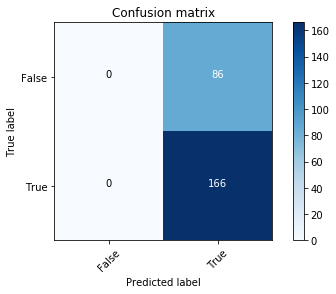

In [201]:
from sklearn.metrics import accuracy_score
import numpy as np
clf = MultinomialNB() 
import itertools

clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

accuracy:   0.790
Confusion matrix, without normalization


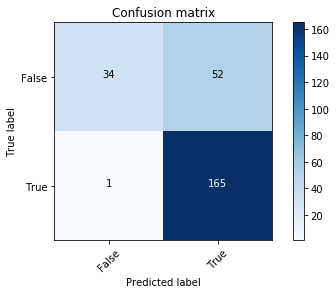

In [202]:
clf = MultinomialNB() 

clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

Testing Linear Models (use a SVM)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.829
Confusion matrix, without normalization


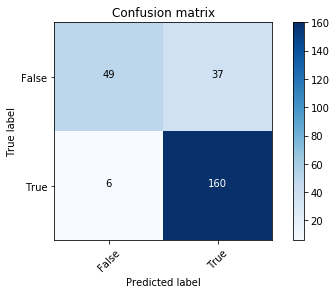

In [203]:
from sklearn.linear_model import PassiveAggressiveClassifier

linear_clf = PassiveAggressiveClassifier(n_iter=50)
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

test if tuning the alpha value for a MultinomialNB:

In [204]:
clf = MultinomialNB(alpha=0.1)

last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = sklearn.metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

    clf = MultinomialNB(alpha=0.1)

last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = sklearn.metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.72619
Alpha: 0.10 Score: 0.80159
Alpha: 0.20 Score: 0.71032
Alpha: 0.30 Score: 0.69048
Alpha: 0.40 Score: 0.68254
Alpha: 0.50 Score: 0.67857
Alpha: 0.60 Score: 0.67460
Alpha: 0.70 Score: 0.66667
Alpha: 0.80 Score: 0.66270
Alpha: 0.90 Score: 0.66270
Alpha: 0.00 Score: 0.72619
Alpha: 0.10 Score: 0.80159
Alpha: 0.20 Score: 0.71032
Alpha: 0.30 Score: 0.69048
Alpha: 0.40 Score: 0.68254
Alpha: 0.50 Score: 0.67857
Alpha: 0.60 Score: 0.67460
Alpha: 0.70 Score: 0.66667
Alpha: 0.80 Score: 0.66270
Alpha: 0.90 Score: 0.66270


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Introspecting models

In [205]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

In [206]:
most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)


False -1.5559137331691804 iglesias
False -1.1897114992331512 inmigrantes
False -1.1431687425763128 podemos
False -1.0855417180650258 iglesia
False -1.0721614734446028 español
False -1.0576894633317788 cabo
False -1.0498401581730936 presos
False -0.9887918912085352 gatorade
False -0.9476714678916744 españoles
False -0.9286752039182544 canción
False -0.910860544133695 llevan
False -0.9084018669994901 concurso
False -0.8858360697387135 jugadores
False -0.8628002160320435 florentino
False -0.8516085632470585 documental
False -0.8508431142168892 marroquíes
False -0.8494739835410139 real
False -0.7933533000810439 ayuntamiento
False -0.7925119513998469 sanidad
False -0.7832010443077323 mujer
False -0.7748160342227235 noche
False -0.7743794859989421 hora
False -0.7724909307847627 comida
False -0.7678400874581957 sorpresa
False -0.7496348238607999 dem
False -0.7406476976120023 pues
False -0.7390407973020787 iniciativa
False -0.7375478070319084 pareja
False -0.7314023090838402 llevar
False -0.72

zipping coefficients to  features and taking a look at the top and bottom of your list:


In [207]:
feature_names = tfidf_vectorizer.get_feature_names()

In [208]:
### Most real
sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20]

[(-8.238400820536933, 'años'),
 (-8.397736409587068, 'dos'),
 (-8.406655936466395, 'si'),
 (-8.49591920389182, 'esta'),
 (-8.566592157939697, 'millones'),
 (-8.590915477453436, 'presidente'),
 (-8.625946135155841, 'gobierno'),
 (-8.629783257550757, 'españa'),
 (-8.632362188255485, 'porque'),
 (-8.637648724353166, 'año'),
 (-8.63808699752381, 'según'),
 (-8.643101665888658, 'pasado'),
 (-8.643956742980663, 'país'),
 (-8.657518509655599, 'parte'),
 (-8.657610930730089, 'tras'),
 (-8.65850165771961, 'madrid'),
 (-8.695816099227091, 'hace'),
 (-8.739893287987423, 'ser'),
 (-8.742377613194716, 'después'),
 (-8.744023287100434, 'solo')]

In [209]:
### Most fake
sorted(zip(clf.coef_[0], feature_names))[:20]

[(-10.368722962628071, 'abandonará'),
 (-10.368722962628071, 'abandone'),
 (-10.368722962628071, 'abaratarán'),
 (-10.368722962628071, 'abasto'),
 (-10.368722962628071, 'abdelhafid'),
 (-10.368722962628071, 'abdelkrim'),
 (-10.368722962628071, 'abducidas'),
 (-10.368722962628071, 'aberrantes'),
 (-10.368722962628071, 'abochornante'),
 (-10.368722962628071, 'abogó'),
 (-10.368722962628071, 'abolida'),
 (-10.368722962628071, 'abolido'),
 (-10.368722962628071, 'abona'),
 (-10.368722962628071, 'abonado'),
 (-10.368722962628071, 'abortos'),
 (-10.368722962628071, 'abracen'),
 (-10.368722962628071, 'abraham'),
 (-10.368722962628071, 'abrazos'),
 (-10.368722962628071, 'abriré'),
 (-10.368722962628071, 'abrumadora')]

In [212]:
 #extract the full list from your current classifier 

tokens_with_weights = sorted(list(zip(feature_names, clf.coef_[0])))


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


accuracy:   0.683
Confusion matrix, without normalization


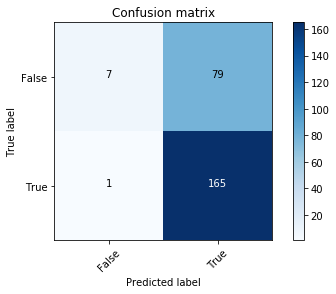

In [213]:
 ##Testing anoher variation of MultinomianNB clf:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(stop_words=spanish, non_negative=True)

hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)
clf = MultinomialNB(alpha=.01)
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.873
Confusion matrix, without normalization


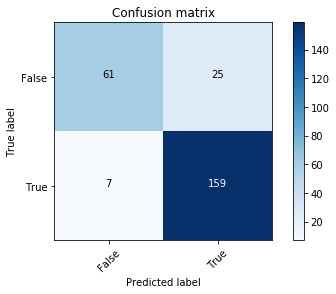

In [214]:
# Another test:
clf = PassiveAggressiveClassifier(n_iter=50)
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

In [227]:
from sklearn.linear_model import LogisticRegression
# 1. Vectorization and logistic regression.
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.8597285067873304
Accuracy for C=0.05: 0.8733031674208145
Accuracy for C=0.25: 0.8778280542986425
Accuracy for C=0.5: 0.8733031674208145
Accuracy for C=1: 0.8778280542986425


In [230]:
final_ngram = LogisticRegression(C=1) 
final_ngram.fit(X_train, y_train)
print ("Final Accuracy: %s" % accuracy_score(y_test, final_ngram.predict(X_test)))

Final Accuracy: 0.8778280542986425


In [226]:
# 2. Vectorization and LinearSVC()
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = tfidf_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = tfidf_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.6470588235294118
Accuracy for C=0.05: 0.6470588235294118
Accuracy for C=0.25: 0.6606334841628959
Accuracy for C=0.5: 0.6742081447963801
Accuracy for C=1: 0.7239819004524887


In [231]:
final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_tfidf.predict(X_test)))

Final Accuracy: 0.8778280542986425


In [233]:
# 3. TF-IDF and logistic regression
from sklearn.svm import LinearSVC
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, svm.predict(X_test))))

Accuracy for C=0.01: 0.9140271493212669
Accuracy for C=0.05: 0.9049773755656109
Accuracy for C=0.25: 0.9095022624434389
Accuracy for C=0.5: 0.9095022624434389
Accuracy for C=1: 0.9095022624434389


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [234]:
final_svm_ngram = LinearSVC(C=0.05)
final_svm_ngram.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_svm_ngram.predict(X_test)))

Final Accuracy: 0.9049773755656109


In [236]:
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, svm.predict(X_test))))

Accuracy for C=0.001: 0.8959276018099548
Accuracy for C=0.005: 0.9004524886877828
Accuracy for C=0.01: 0.8868778280542986
Accuracy for C=0.05: 0.8823529411764706
Accuracy for C=0.1: 0.8823529411764706


In [237]:
final = LinearSVC(C=0.005)
final.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final.predict(X_test)))

Final Accuracy: 0.9004524886877828
